In [1]:
#@title <h3>Step 1: Install Required Libraries</h3>
%pip install ultralytics folium
# You already have folium and ultralytics installed, but it's good practice to keep this.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.5 MB/s eta 0:00:00


In [2]:
#@title <h3>Step 2: Connect to Drive, Analyze Video, Save Annotated Frames, and Geo-tag Alerts</h3>
import cv2
import numpy as np
from ultralytics import YOLO
from google.colab import files, drive
from collections import Counter
import os
import shutil # Used for cleaning up folders
from IPython.display import display as ipydisplay, Image

# --- 1. CONNECT TO GOOGLE DRIVE ---
print("📁 Connecting to Google Drive...")
# Use force_remount=True to ensure the drive is accessible if there were previous mounting issues
drive.mount('/content/drive', force_remount=True)
print("✅ Google Drive connected.")

# --- 2. CONFIGURATION ---
# IMPORTANT: Update this path to point to your model in Google Drive
MODEL_PATH = '/content/drive/MyDrive/IBM_Datathon_AntiPoaching/Final_AntiPoaching_Model_V1.onnx'
CONFIDENCE_THRESHOLD = 0.4
# Define threat scores for each object class
THREAT_SCORES = {
    "poacher": 10, "gun": 8, "knife": 7, "machete": 7,
    "animal_trap": 9, "fire": 6, "vehicle": 3, "person": 1, "animal": 0,
    "Weapon_Tool": 9
}
# GPS path simulation starting point (Example: Bannerghatta National Park area)
PATROL_START_LAT = 12.8005
PATROL_START_LON = 77.5794

# --- New Configuration for Visuals ---
FRAMES_FOLDER = "/content/temp_frames/"
ANNOTATED_OUTPUT_DIR = "/content/ultralytics_output"
RUN_NAME = "geo_alerts"
# The final directory where annotated images are saved (created by Ultralytics)
PROCESSED_FOLDER = os.path.join(ANNOTATED_OUTPUT_DIR, RUN_NAME)
# Minimum threat score to qualify as an 'alert' and be geo-tagged
ALERT_SCORE_THRESHOLD = 8


# --- 3. HELPER FUNCTION: SIMULATE GPS PATH ---
def simulate_gps_path(start_lat, start_lon, num_frames):
    """Generates a simple, slightly drifting GPS path for each video frame."""
    print(f"🌍 Simulating a GPS patrol route for {num_frames} frames...")
    # Smaller drift for a tighter patrol route in an area like a park
    lat_drift = np.random.randn(num_frames) * 0.000005
    lon_drift = np.random.randn(num_frames) * 0.000005
    lats = start_lat + np.cumsum(lat_drift)
    lons = start_lon + np.cumsum(lon_drift)
    path = list(zip(lats, lons))
    print("✅ GPS path simulation complete.")
    return path

# --- 4. MAIN EXECUTION ---
print("\n--- STAGE 2: INITIALIZING ANALYSIS ---")

# Clean up previous runs folders
if os.path.exists(FRAMES_FOLDER): shutil.rmtree(FRAMES_FOLDER)
if os.path.exists(ANNOTATED_OUTPUT_DIR): shutil.rmtree(ANNOTATED_OUTPUT_DIR)
os.makedirs(FRAMES_FOLDER)

# Check and load model
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model not found at: {MODEL_PATH}. Please check the path and folder name in your Google Drive.")

model = YOLO(MODEL_PATH)
all_detections = Counter()
geo_tagged_alerts = []

# --- Upload Video ---
print("\nPlease upload the video file to be analyzed.")
uploaded = files.upload()
if not uploaded:
    raise Exception("No file uploaded. Please run the cell again.")

# Get the path of the uploaded video
video_path = list(uploaded.keys())[0]
print(f"\nProcessing video: '{video_path}'...")

# --- Extract Frames & Simulate GPS ---
cap = cv2.VideoCapture(video_path)
# FIX: Use CAP_PROP_FRAME_COUNT, the correct and standard constant
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
if frame_count == 0:
    raise Exception("Could not read video file or video has no frames.")
gps_path = simulate_gps_path(PATROL_START_LAT, PATROL_START_LON, frame_count)

# --- Process Video Frame by Frame ---
for frame_num in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break

    # 1. Save the frame temporarily
    frame_save_path = os.path.join(FRAMES_FOLDER, f"frame_{frame_num:05d}.jpg")
    cv2.imwrite(frame_save_path, frame)

    # 2. Run YOLOv8 prediction and SAVE the annotated image
    results = model.predict(source=frame_save_path,
                            conf=CONFIDENCE_THRESHOLD,
                            verbose=False,
                            save=True, # Critical: saves the annotated image
                            project=ANNOTATED_OUTPUT_DIR,
                            name=RUN_NAME,
                            exist_ok=True)

    # Path to the annotated frame saved by Ultralytics
    annotated_path = os.path.join(PROCESSED_FOLDER, os.path.basename(frame_save_path))

    frame_threat_score = 0
    current_frame_detections = []

    # 3. Process YOLO results
    if len(results[0].boxes) > 0:
        for box in results[0].boxes:
            class_id = int(box.cls[0])
            class_name = model.names.get(class_id, f"Class_{class_id}")

            threat_score_value = THREAT_SCORES.get(class_name, 0)

            all_detections[class_name] += 1
            frame_threat_score += threat_score_value
            current_frame_detections.append(class_name)

        # 4. Geo-tag if threat score is above threshold
        if frame_threat_score >= ALERT_SCORE_THRESHOLD:
            frame_location = gps_path[frame_num]
            unique_detections = Counter(current_frame_detections)

            geo_tagged_alerts.append({
                "location": frame_location,
                "score": frame_threat_score,
                "detections": dict(unique_detections),
                "frame_num": frame_num,
                "image_path": annotated_path # Store the path to the annotated image
            })

    # Simple progress print
    if (frame_num + 1) % 50 == 0:
        print(f"  Processed frame {frame_num + 1}/{frame_count}")

cap.release()
# Clean up temporary frames directory
if os.path.exists(FRAMES_FOLDER): shutil.rmtree(FRAMES_FOLDER)

print("\n--- ✅ ANALYSIS COMPLETE ---")
print(f"High-threat events logged with GPS data: {len(geo_tagged_alerts)}")
print("Overall Detected Objects Summary:", dict(all_detections))

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
📁 Connecting to Google Drive...
Mounted at /content/drive
✅ Google Drive connected.

--- STAGE 2: INITIALIZING ANALYSIS ---
WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.

Please upload the video file to be analyzed.


Saving WhatsApp Video 2025-10-11 at 20.11.42_706998e5.mp4 to WhatsApp Video 2025-10-11 at 20.11.42_706998e5.mp4

Processing video: 'WhatsApp Video 2025-10-11 at 20.11.42_706998e5.mp4'...
🌍 Simulating a GPS patrol route for 168 frames...
✅ GPS path simulation complete.
Loading /content/drive/MyDrive/IBM_Datathon_AntiPoaching/Final_AntiPoaching_Model_V1.onnx for ONNX Runtime inference...
requirements: Ultralytics requirements ['onnx', 'onnxruntime'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 3.9s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect

Using ONNX Runtime 1.23.1 CPUExecutionProvider
Results saved to /content/ultralytics_output/geo_alerts
Results saved to /content/ultralytics_output/geo_alerts
Results saved to /content/ultralytics_output/geo_alerts
Results saved to /content/ultralytics_output/geo_alerts
Results saved to /content/ultralytics_output/geo_alerts
Results saved to /content/ultralytics_output/geo_alerts
Re

In [3]:
#@title <h3>Step 3: Generate and Display Dynamic Threat Map</h3>
import folium
from IPython.display import display as ipydisplay
import numpy as np

print("\n--- STAGE 3: GENERATING DYNAMIC THREAT MAP ---")

# Safely check if variables from Step 2 are available
if 'PATROL_START_LAT' not in globals():
    PATROL_START_LAT = 12.8005
    PATROL_START_LON = 77.5794
    geo_tagged_alerts = [] # Initialize if Step 2 was skipped
    gps_path = []

m = folium.Map(
    location=[PATROL_START_LAT, PATROL_START_LON],
    zoom_start=17,
    # Using Google Satellite tiles for better context
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google Satellite'
)

# Plot the simulated patrol route
if gps_path:
    folium.PolyLine(
        locations=gps_path, color='lightblue', weight=4,
        opacity=0.8, tooltip="Simulated Patrol Route"
    ).add_to(m)

if not geo_tagged_alerts:
    print("✅ No high-threat events were detected to plot on the map.")
else:
    print(f"  plotting {len(geo_tagged_alerts)} high-threat alerts...")

    # Determine the center of the alerts to set a good map view
    avg_lat = np.mean([alert['location'][0] for alert in geo_tagged_alerts])
    avg_lon = np.mean([alert['location'][1] for alert in geo_tagged_alerts])
    m.location = [avg_lat, avg_lon] # Re-center the map

    for alert in geo_tagged_alerts:
        lat, lon = alert['location']
        # Format detections for the popup
        detections_str = '<br>'.join([f"<b>{cls}:</b> {count}" for cls, count in alert['detections'].items()])

        # Define marker style based on the threat score
        color = 'green'
        icon_type = 'leaf' # Low threat
        if alert['score'] >= 15:
            color = 'red'
            icon_type = 'exclamation-triangle' # Critical threat
        elif alert['score'] >= 8:
            color = 'orange'
            icon_type = 'bolt' # High threat

        popup_html = f"""
        <div style="font-family: sans-serif;">
            <h4>🚨 <b>THREAT DETECTED</b> (Frame {alert['frame_num']})</h4>
            <p><b>Threat Score:</b> {alert['score']}</p>
            <p><b>Detections:</b></p>
            <p>{detections_str}</p>
            <i>Location: Lat: {lat:.5f}, Lon: {lon:.5f}</i>
        </div>
        """
        folium.Marker(
            location=[lat, lon],
            popup=folium.Popup(popup_html, max_width=300),
            icon=folium.Icon(color=color, icon=icon_type, prefix='fa'),
            tooltip=f"Threat Score: {alert['score']}"
        ).add_to(m)

ipydisplay(m)
print("✅ Dynamic threat map displayed.")


--- STAGE 3: GENERATING DYNAMIC THREAT MAP ---
  plotting 17 high-threat alerts...


✅ Dynamic threat map displayed.



--- STAGE 4: DISPLAYING VISUAL EVIDENCE ---
🖼️ **VISUAL EVIDENCE (First 3 of 17 High-Threat Frames):**

--- Frame 0 ---


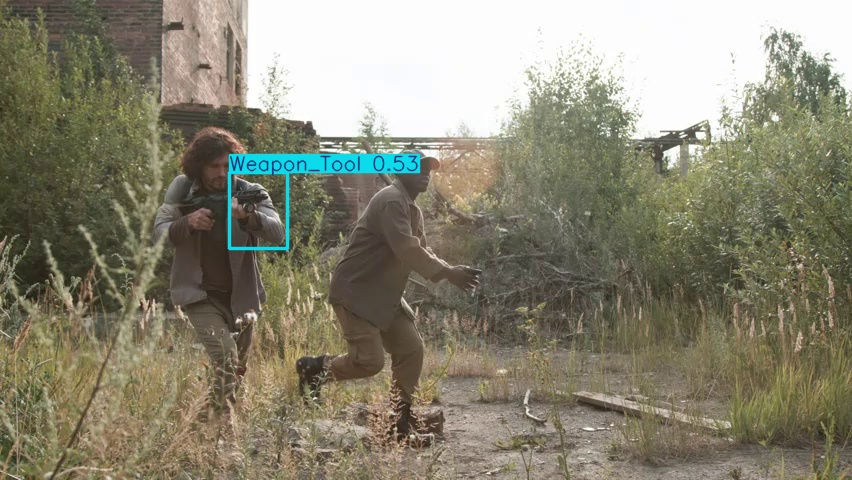


--- Frame 1 ---


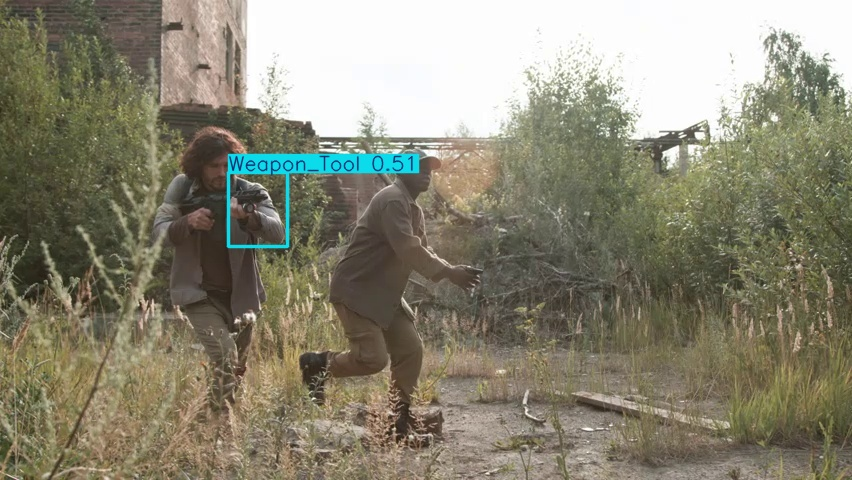


--- Frame 2 ---


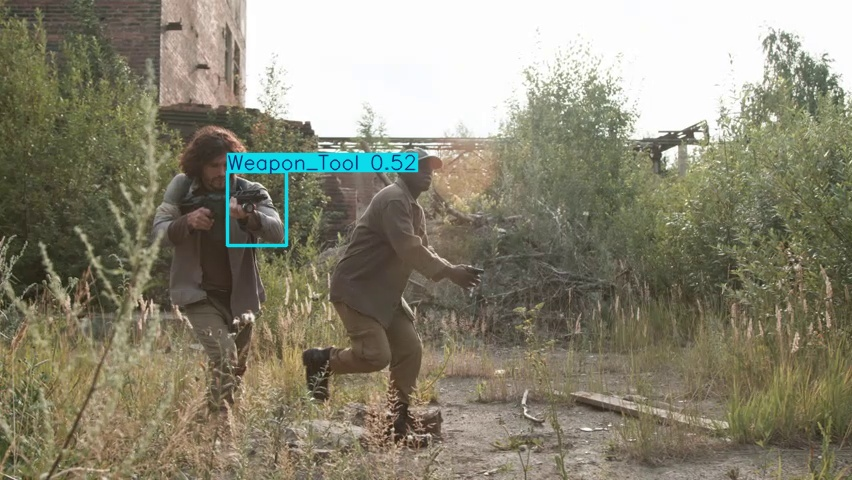


... and 14 more high-threat frames were detected.

--- ✅ STAGE 4 COMPLETE ---


In [4]:
#@title <h3>Step 4: Display Visual Evidence (Annotated Frames)</h3>
from IPython.display import display as ipydisplay, Image
import os
import numpy as np

print("\n--- STAGE 4: DISPLAYING VISUAL EVIDENCE ---")

if 'geo_tagged_alerts' in globals() and geo_tagged_alerts:

    # Get the image paths for all high-threat frames
    high_threat_images = [alert['image_path'] for alert in geo_tagged_alerts if alert['score'] >= 8]

    # Use a set for unique paths and sort them by filename (which contains the frame number)
    unique_images_to_display = sorted(list(set(high_threat_images)))

    # Define how many images to show
    limit = 3
    print(f"🖼️ **VISUAL EVIDENCE (First {min(limit, len(unique_images_to_display))} of {len(unique_images_to_display)} High-Threat Frames):**")

    for i, img_path in enumerate(unique_images_to_display[:limit]):
        # Extract frame number from the file name for a clear label
        frame_num_str = os.path.basename(img_path).replace('frame_', '').replace('.jpg', '')
        # Ensure the frame number is an integer for display
        try:
            frame_number = int(frame_num_str)
        except ValueError:
            frame_number = "N/A"

        print(f"\n--- Frame {frame_number} ---")
        ipydisplay(Image(filename=img_path))

    if len(unique_images_to_display) > limit:
        print(f"\n... and {len(unique_images_to_display) - limit} more high-threat frames were detected.")

else:
    print("No high-threat events were logged to display visual evidence.")

print("\n--- ✅ STAGE 4 COMPLETE ---")